# How to convert DNN into BNN

<div class="admonition info">
    <p class="admonition-title">Info</p>
    <p>
        This guide use <code>v2</code> API of the package.
    </p>
</div>

<div class="admonition goal">
    <p class="admonition-title">Goal</p>
    <p>
        This notebook aims to showcase how can you convert a statistical deep neural network that predict a point into a bayesian neural network that predict the distribution instead. 
    </p>
</div>

Let us start by importing libraries.

In [1]:
import jax
import jax.numpy as jnp
import inspeqtor as sq

## Get synthetic dataset ready 🚀

Here we are working with synthetic dataset. So, we need to define a simulator, perform an experiment, prepare the dataset for model training/inference, benchmarking. Luckily, `inspeqtor` provide a serveral helper functions and predefined noise model for user to quickly get stuff setting up.

In [2]:
def get_data():
    # This is the predefined noise model that we are going to work with.
    data_model = sq.predefined.get_predefined_data_model_m1()

    # Now, we use the noise model to performing the data using simulator.
    sample_size = 100
    exp_data, _, _, _ = sq.predefined.generate_single_qubit_experimental_data(
    key=jax.random.key(0),
    hamiltonian=data_model.total_hamiltonian,
    sample_size=sample_size,
    strategy=sq.predefined.SimulationStrategy.SHOT,
    qubit_inforamtion=data_model.qubit_information,
    control_sequence=data_model.control_sequence,
    method=sq.predefined.WhiteboxStrategy.TROTTER,
    trotter_steps=10_000,
)

    # Now we can prepare the dataset that ready to use.
    whitebox = sq.physics.make_trotterization_solver(
        data_model.ideal_hamiltonian,
        data_model.control_sequence.total_dt,
        data_model.dt,
        trotter_steps=10_000,
        y0=jnp.eye(2, dtype=jnp.complex128)
    )
    loaded_data = sq.predefined.prepare_data(
        exp_data, data_model.control_sequence, whitebox
    )

    # Here, we just bundling things up for convinience uses.
    key = jax.random.key(0)
    key, random_split_key = jax.random.split(key)
    (
        train_pulse_parameters,
        train_unitaries,
        train_expectation_values,
        test_pulse_parameters,
        test_unitaries,
        test_expectation_values,
    ) = sq.experimental.utils.random_split(
        random_split_key,
        int(loaded_data.control_parameters.shape[0] * 0.1),  # Test size
        loaded_data.control_parameters,
        loaded_data.unitaries,
        loaded_data.observed_values,
    )

    shots = loaded_data.experiment_data.config.shots

    train_binaries = sq.experimental.utils.eigenvalue_to_binary(
        sq.experimental.utils.expectation_value_to_eigenvalue(train_expectation_values, shots)
    )
    train_binaries = jnp.swapaxes(jnp.swapaxes(train_binaries, 1, 2), 0, 1)

    test_binaries = sq.experimental.utils.eigenvalue_to_binary(
        sq.experimental.utils.expectation_value_to_eigenvalue(test_expectation_values, shots)
    )

    test_binaries = jnp.swapaxes(jnp.swapaxes(test_binaries, 1, 2), 0, 1)

    assert train_binaries.shape == (shots, train_pulse_parameters.shape[0], 18)
    assert test_binaries.shape == (shots, test_pulse_parameters.shape[0], 18)

    train_data = sq.optimize.DataBundled(
        control_params=sq.experimental.predefined.drag_feature_map(train_pulse_parameters),
        unitaries=train_unitaries,
        observables=train_binaries,
        aux=train_expectation_values,
    )

    test_data = sq.optimize.DataBundled(
        control_params=sq.experimental.predefined.drag_feature_map(test_pulse_parameters),
        unitaries=test_unitaries,
        observables=test_binaries,
        aux=test_expectation_values,
    )
    # Return data ready to use.
    return data_model, loaded_data, train_data, test_data

data_model, loaded_data, train_data, test_data = get_data()

## Routes to convert DNN model to BNN model

`inspeqtor` provides serveral ways to convert DNN to BNN and user can also create the BNN from scratch too! For the predefined models or model defined using `flax`, `numpyro.contrib.module` implemented the function that transform the statistical model to probabilistic model with ease. Thus, `inspeqtor` provides a wrapper function `make_flax_probabilistic_graybox_model` that help convet user defined model into a proper probabilistic Graybox model. Here are examples of how to do it.

For the `linen` models, user has to use `random_flax_module` for a `flax_module` argument to `make_flax_probabilistic_graybox_model` function. Similar to `models` version, the adapter function that transform model's output into expectation values has to be use appropiately.

In [ ]:
from numpyro.contrib.module import random_flax_module

base_model, adapter_fn, flax_module = (
    sq.models.linen.UnitaryModel([10, 10]),
    sq.models.adapter.toggling_unitary_to_expvals,
    random_flax_module,
)

In [ ]:
base_model, adapter_fn, flax_module = (
    sq.models.linen.WoModel([5], [5]),
    sq.models.adapter.observable_to_expvals,
    random_flax_module,
)

In [ ]:
from flax import nnx
from numpyro.contrib.module import random_nnx_module

base_model, adapter_fn, flax_module = (
    sq.models.nnx.UnitaryModel([8, 8], rngs=nnx.Rngs(0)),
    sq.models.adapter.toggling_unitary_to_expvals,
    random_nnx_module,
)

In [ ]:
base_model, adapter_fn, flax_module = (
    sq.models.nnx.WoModel([8, 4, 6], [6, 4, 5], rngs=nnx.Rngs(0)),
    sq.models.adapter.observable_to_expvals,
    random_nnx_module,
)

Finally, we can define `graybox` model with the choice of the DNN model. For the custom `linen` and `nnx` models, you have to define a corresponding `adapter_fn` as well.

In [7]:
graybox_model = sq.probabilistic.make_flax_probabilistic_graybox_model(
    name="graybox",
    base_model=base_model,
    adapter_fn=adapter_fn,
    prior=sq.probabilistic.dist.Normal(0, 1),
    flax_module=flax_module,
)

nnx.display(base_model)

In the case that you need a completely in control of the model behavior. You can define the probabilistic mdoel from scratch too. You can do this using our primitive bayesian neural network components that design to be compatible with `numpyro`.

Below is $\hat{W}_{O}$-based model defined from scratch to mirror the `flax` implementation. Note that we use `sq.probabilistic.dense_layer` for our mathematical operation. The mental model of defining probabilistic model using our primitive as example below is that you can define it as operating on point prediction, while `numpyro` will handle the distribution part for you.

In [8]:
base_model = sq.probabilistic.WoModel("graybox", (5,), (5,))
adapter_fn = sq.model.observable_to_expvals

graybox_model = sq.probabilistic.make_probabilistic_graybox_model(
    base_model, adapter_fn
)

You can inspect the model using `sq.probabilistic.get_trace`. Below, we visualize the trace of model using `nnx.display`. Note that `get_trace` handle the random key for you under the hood. User can suppliment their own key if desire.

In [9]:
from flax import nnx

nnx.display(sq.probabilistic.get_trace(graybox_model)(test_data.control_params, test_data.unitaries))

## Stochastic Variational Inference of BNN

Let import the goodies to use. 

In [10]:
import numpyro
from numpyro.infer import (
    SVI,
    TraceMeanField_ELBO,
)
from alive_progress import alive_it

You will see below that probabilistic model (`model` variable) accept `graybox` which can be defined from multiple ways demonstrated previously. In the following code snippet, we also use custom guide and custom training loop to demonstrate the flexibility.

In [11]:
model = sq.probabilistic.make_probabilistic_model(
    predictive_model=graybox_model,
)

guide = sq.probabilistic.auto_diagonal_normal_guide_v3(
    model,
    train_data.control_params,
    train_data.unitaries,
    train_data.observables,
    init_dist_fn=sq.probabilistic.bnn_init_dist_fn,
    init_params_fn=sq.probabilistic.bnn_init_params_fn
)

NUM_STEPS = 10_000
optimizer = sq.optimize.get_default_optimizer(NUM_STEPS)

svi = SVI(
    model=model,
    guide=guide,
    optim=numpyro.optim.optax_to_numpyro(optimizer),
    loss=TraceMeanField_ELBO(),
)

svi_state = svi.init(
    rng_key=jax.random.key(0),
    control_parameters=train_data.control_params,
    unitaries=train_data.unitaries,
    observables=train_data.observables,
)

update_fn = sq.probabilistic.make_update_fn(
    svi,
    control_parameters=train_data.control_params,
    unitaries=train_data.unitaries,
    observables=train_data.observables,
)

eval_fn = sq.probabilistic.make_evaluate_fn(
    svi,
    control_parameters=test_data.control_params,
    unitaries=test_data.unitaries,
    observables=test_data.observables,
)

eval_losses = []
losses = []
for i in alive_it(range(NUM_STEPS), force_tty=True):
    svi_state, loss = jax.jit(update_fn)(svi_state)
    eval_loss = jax.jit(eval_fn)(svi_state)
    losses.append(loss)
    eval_losses.append(eval_loss)

svi_result = sq.probabilistic.SVIRunResult(
    svi.get_params(svi_state), svi_state, jnp.stack(losses), jnp.stack(eval_losses)
)

|████████████████████████████████████████| 10000/10000 [100%] in 35.7s (279.84/s


In [12]:
sq.probabilistic.get_trace(guide)()

OrderedDict([('graybox/shared.dense_0.kernel_loc',
              {'type': 'param',
               'name': 'graybox/shared.dense_0.kernel_loc',
               'fn': <function numpyro.util.identity(x, *args, **kwargs)>,
               'args': (Array([[0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0.],
                       [0., 0., 0., 0., 0.]], dtype=float64),),
               'kwargs': {},
               'value': Array([[0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0.],
                      [0., 0., 0., 0., 0.]], dtyp

## Visualize the Negative ELBO loss

Belows, we rescale the loss with the number of the sample and plot it with `matplotlib`.

In [13]:
import matplotlib.pyplot as plt

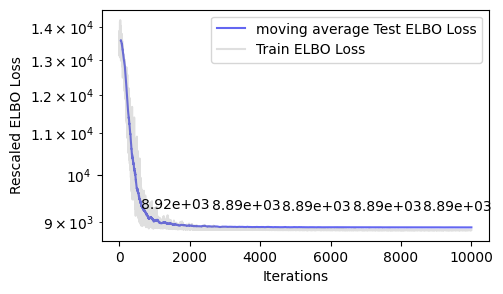

In [14]:
rescaled_eval_losses = svi_result.eval_losses / test_data.control_params.shape[0]
rescaled_train_losses = svi_result.losses / train_data.control_params.shape[0]

iterations = jnp.arange(len(rescaled_train_losses))
fig, ax = plt.subplots(figsize=(5, 3))
ax = sq.visualization.plot_loss_with_moving_average(
    iterations,
    rescaled_eval_losses,
    ax=ax,
    color="#6366f1",
    label="moving average Test ELBO Loss",
)
ax = sq.visualization.plot_loss_with_moving_average(
    iterations,
    rescaled_train_losses,
    ax,
    window=1,
    annotate_at=[],
    color="gray",
    alpha=0.25,
    label="Train ELBO Loss",
)
ax.set_yscale("log")
ax.set_xlabel("Iterations")
ax.set_ylabel("Rescaled ELBO Loss")
ax.legend()


In [15]:
import tempfile
from pathlib import Path


with tempfile.TemporaryDirectory() as tmpdir:

    model_path = Path(tmpdir)

    # Create the path with parents if not existed already
    model_path.mkdir(parents=True, exist_ok=True)

    model_state = sq.models.ModelData(
        params=svi_result.params,
        config={}
    )

    model_state.to_file(model_path /"model.json")

    reloaded_model = sq.models.ModelData.from_file(model_path / "model.json")

assert reloaded_model == model_state

## Two ways of making posterior predictive model

First, let us prepare our testing point and import helper function.

In [17]:
from numpyro.infer import Predictive

params = test_data.control_params[0]
unitary = test_data.unitaries[0]

### From guide

This is the way with a guide from elsewhere. We have to completely rely on the `Predictive` to do the work for us. Because we did not assume that the guide is create with structural approach in mind.

In [ ]:
def make_predictive_fn_v2(
    model,
    guide,
    params,
    shots: int,
):
    predictive = Predictive(model, guide=guide, params=params, num_samples=shots)

    def predictive_fn(*args, **kwargs):
        return predictive(*args, **kwargs)

    return predictive_fn


predictive_fn_from_guide = make_predictive_fn_v2(
    sq.probabilistic.make_probabilistic_model(
        predictive_model=graybox_model, log_expectation_values=True
    ),
    guide,
    model_state.params,
    shots=1000,
)

guide_expectation_values = predictive_fn_from_guide(jax.random.key(0), params, unitary)[
    "expectation_values"
]

### From variational parameters

With our `auto_guide`, the variational parameters are keep in the sturture that is ready to use. 

In [19]:
posterior_fn = sq.probabilistic.make_posterior_fn(
    model_state.params, sq.probabilistic.bnn_init_dist_fn
)

base_model = sq.probabilistic.WoModel("graybox", (5,), (5,), priors_fn=posterior_fn)
adapter_fn = sq.model.observable_to_expvals

graybox_model = sq.probabilistic.make_probabilistic_graybox_model(
    base_model, adapter_fn
)

posterior_model = sq.probabilistic.make_probabilistic_model(
    predictive_model=graybox_model,
    log_expectation_values=True,
)

In [20]:
posterior_expectation_values = Predictive(model=posterior_model, num_samples=1000)(
    jax.random.key(0), params, unitary
)["expectation_values"]

<Axes: ylabel='Count'>

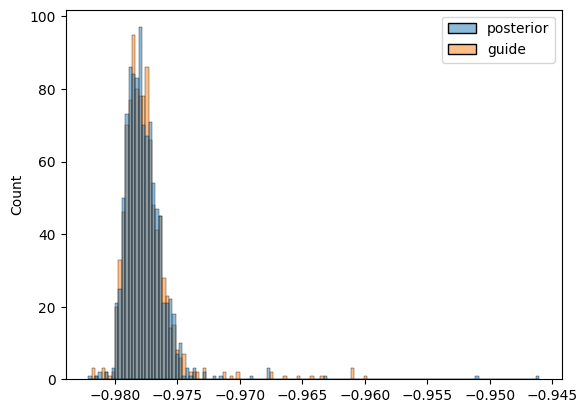

In [21]:
import seaborn as sns
sns.histplot({
    "posterior": posterior_expectation_values[:, -1], 
    "guide": guide_expectation_values[:, -1]
})